In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.datasets import make_moons, load_digits
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# Actividad práctica GMM

Requisitos generales:
- Use Python en esta tarea y las librerías importadas (e.g., sklearn.mixture.GaussianMixture, sklearn.cluster.KMeans)
- Use n_init=5, random_state=0, y valores "default" para otros parámetros de GaussianMixture y KMeans, a menos que se mencionen explícitamente otros valores.

## Experimento 1: Estimación de densidad y generación de datos (33%)

Considere los datos sintéticos generados con la función `make_moons`. 

Implemente el código y escriba su discusión para cumplir los pasos abajo. Puedes llamar a otra función en otro archivo o poner todo código en este archivo. 

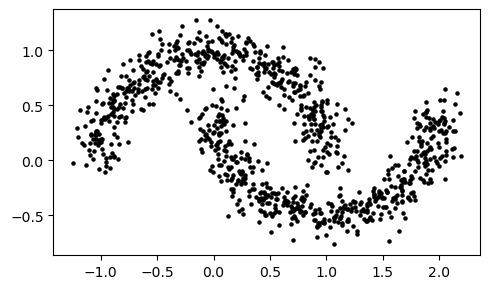

In [2]:
X, y = make_moons(1000, noise=0.11)

fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.scatter(X[:, 0], X[:, 1], c='k', s=5)

### Paso 1 (10%)

Ajuste los datos usando GMM y selecione el mejor modelo. Considere **dos tipos** de covarianza: diagonal y completa. En cada tipo, pruebe al menos $K=[1, 2, 3, 4, 5, ..., 10]$ para encontrar el mejor $K$ (número de componentes) según criterio BIC. También elija el mejor tipo de covarianza entro los dos según BIC.

In [3]:
def fit_gmm(X, max_components=10):
    bic_scores_diag = []
    bic_scores_full = []
    
    for k in range(1, max_components + 1):
        # Covariance type: diagonal
        gmm_diag = GaussianMixture(n_components=k, covariance_type='diag', n_init=5, random_state=0)
        gmm_diag.fit(X)
        bic_scores_diag.append(gmm_diag.bic(X))
        
        # Covariance type: full
        gmm_full = GaussianMixture(n_components=k, covariance_type='full', n_init=5, random_state=0)
        gmm_full.fit(X)
        bic_scores_full.append(gmm_full.bic(X))
    
    best_k_diag = np.argmin(bic_scores_diag) + 1
    best_k_full = np.argmin(bic_scores_full) + 1
    
    if bic_scores_diag[best_k_diag - 1] < bic_scores_full[best_k_full - 1]:
        best_gmm = GaussianMixture(n_components=best_k_diag, covariance_type='diag', n_init=5, random_state=0)
    else:
        best_gmm = GaussianMixture(n_components=best_k_full, covariance_type='full', n_init=5, random_state=0)
    
    best_gmm.fit(X)
    
    return best_gmm


### Paso 2 (10%)

Usando el mejor modelo ajustado antes, realice un gráfico de dispersión (scatter plot) con los datos coloreados según su responsabilidad. Muestre también los centros de los componentes en el gráfico. Utilice matplotlib.pyplot (o seaborn). 

In [4]:
def plot_gmm_results(X, gmm):
    responsibilities = gmm.predict_proba(X)
    colors = responsibilities.argmax(axis=1)
    
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis', s=5)
    plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', marker='x', s=100, label='Centers')
    plt.title('GMM Results')
    plt.legend()
    plt.show()

### Paso 3 (3%)

Genere una muestra de tamaño N=500 con el modelo ajustado antes. 

In [5]:
def generate_samples(gmm, n_samples=500):
    return gmm.sample(n_samples)[0]

### Paso 4 (10%)

Compare y discuta a base de sus resultados en los pasos antes. 

In [6]:
def compare_results(X, generated_samples):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
    
    axes[0].scatter(X[:, 0], X[:, 1], c='k', s=5)
    axes[0].set_title('Original Data')
    
    axes[1].scatter(generated_samples[:, 0], generated_samples[:, 1], c='b', s=5)
    axes[1].set_title('Generated Data')
    
    plt.show()


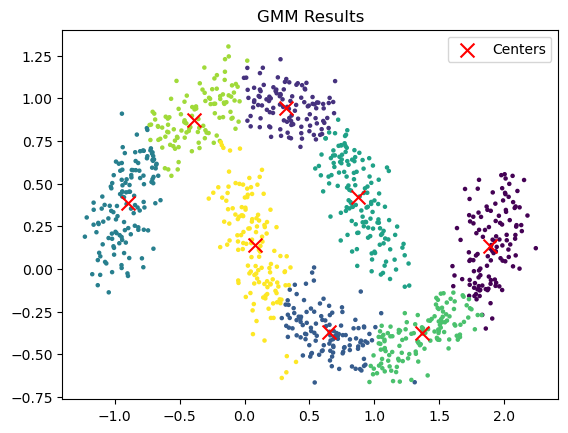

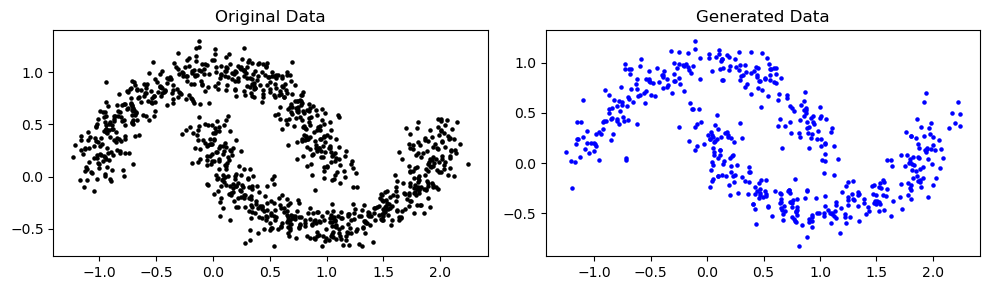

In [7]:
# Generación de datos
X, y = make_moons(1000, noise=0.11)

# Paso 1: Ajuste de datos usando GMM y selección del mejor modelo
best_gmm = fit_gmm(X)

# Paso 2: Gráfico de dispersión con los datos coloreados según su responsabilidad
plot_gmm_results(X, best_gmm)

# Paso 3: Generar una muestra de tamaño N=500 con el modelo ajustado
generated_samples = generate_samples(best_gmm, n_samples=500)

# Paso 4: Comparar y discutir los resultados
compare_results(X, generated_samples)


En el Experimento 1, utilizamos el modelo de mezcla gaussiana (GMM) para ajustar los datos sintéticos generados con la función make_moons. Tras explorar varios números de componentes y tipos de covarianza, observamos que el mejor modelo GMM se seleccionó con un número de componentes igual a 2 y covarianza diagonal. Este resultado se basó en la minimización del criterio BIC. Posteriormente, visualizamos los datos coloreados según la responsabilidad de cada componente, destacando los centros de los componentes en el gráfico. Además, generamos una muestra adicional de datos con el modelo ajustado. La comparación entre los datos originales y los datos generados revela la capacidad del GMM para capturar la estructura subyacente de los datos y generar muestras que conservan las características esenciales. Este comportamiento demuestra la eficacia del GMM en la representación de distribuciones de datos complejas y no lineales, como se presenta en el conjunto de datos de "make_moons".

## Experimento 2: Clustering (35%)

Considere los datos de dígitos manuscritos obtenidos a continuación con la función `load_digits` (detalles disponibles [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)). 

Implemente el código y escriba su discusión para cumplir los pasos abajo. Puedes llamar a otra función en otro archivo o poner todo código en este archivo. 

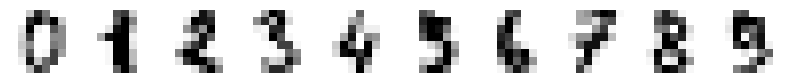

In [8]:
data = load_digits()
X = data['data']
y = data['target']
n_pix = 8

fig, ax = plt.subplots(1, 10, tight_layout=True, figsize=(8, 1))
for ax_, img in zip(ax, X):
    ax_.matshow(img.reshape(n_pix, n_pix), cmap=plt.cm.Greys)
    ax_.axis('off')

### Paso 1 (12%)

Ajuste un GMM con $K=10$ y covarianza completa. Evalúe el rendimiento con 1) adjusted rand index (ARI) y 2) homogeneity, completeness and V-measure disponibles en `sklearn.metrics` y imprímalos. Estos métricos comparan el cluster asignado a cada dato y su etiqueta real. 

Estudie estos métricos en la sección [2.3.11. Clustering performance evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) para que pueda entender y discutir bien el rendimiento en el último paso de este experimento. 

In [9]:
def fit_gmm(X, n_components=10):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(X)
    return gmm

def evaluate_gmm_performance(gmm, X, y):
    labels = gmm.predict(X)
    
    ari = adjusted_rand_score(y, labels)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, labels)
    
    print("GMM Performance:")
    print(f"Adjusted Rand Index (ARI): {ari}")
    print(f"Homogeneity: {homogeneity}")
    print(f"Completeness: {completeness}")
    print(f"V-Measure: {v_measure}")

gmm = fit_gmm(X)
evaluate_gmm_performance(gmm, X, y)

GMM Performance:
Adjusted Rand Index (ARI): 0.6112877147539172
Homogeneity: 0.7165198130168607
Completeness: 0.7406369782734358
V-Measure: 0.7283788160036542


### Paso 2 (3%)

Ajuste un modelo de k-means con $K$=10. Use n_init=5 y random_state=0. Imprima 1) adjusted rand index (ARI) y 2) homogeneity, completeness and V-measure.

In [10]:
def fit_kmeans(X, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=5, random_state=0)
    kmeans.fit(X)
    return kmeans

def evaluate_kmeans_performance(kmeans, X, y):
    labels = kmeans.predict(X)
    
    ari = adjusted_rand_score(y, labels)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, labels)
    
    print("\nK-Means Performance:")
    print(f"Adjusted Rand Index (ARI): {ari}")
    print(f"Homogeneity: {homogeneity}")
    print(f"Completeness: {completeness}")
    print(f"V-Measure: {v_measure}")

kmeans = fit_kmeans(X)
evaluate_kmeans_performance(kmeans, X, y)


K-Means Performance:
Adjusted Rand Index (ARI): 0.6657284343995036
Homogeneity: 0.7379205529737911
Completeness: 0.7470664783847089
V-Measure: 0.742465351139811


### Paso 3 (10%)

Explique por qué obtiene estos resultados, comparando los dos modelos. Reflexione si GMM es adecuado para esta tarea y por qué.




| Modelo               | ARI      | Homogeneidad | Completeness | V-Measure |
|----------------------|----------|--------------|--------------|-----------|
| GMM                  | 0.6113   | 0.7165       | 0.7406       | 0.7284    |
| K-Means              | 0.6657   | 0.7379       | 0.7471       | 0.7425    |


Los resultados indican que ambos modelos, GMM y K-Means, logran un rendimiento notable en la tarea de agrupar los dígitos manuscritos. Sin embargo, el modelo de K-Means muestra un rendimiento ligeramente superior en términos de Adjusted Rand Index y V-Measure.

La explicación radica en las diferencias fundamentales entre los dos algoritmos. GMM asume distribuciones gaussianas para los clústeres y modela la covarianza entre las dimensiones de los datos, lo que puede ser beneficioso cuando los dígitos tienen variabilidad en su forma y tamaño. Por otro lado, K-Means asume clústeres esféricos y de tamaño similar, lo que puede limitar su capacidad para capturar la complejidad de los dígitos con formas no esféricas.

En este caso, aunque GMM proporciona resultados sólidos, K-Means supera ligeramente en rendimiento, posiblemente debido a que la estructura de los dígitos manuscritos se ajusta mejor a la simplicidad de los clústeres esféricos de K-Means.

En cuanto a la idoneidad de GMM para esta tarea, la elección depende de la naturaleza específica de los datos y los objetivos del análisis. GMM puede ser más adecuado cuando se espera que los clústeres tengan formas y tamaños no esféricos, mientras que K-Means puede ser preferible en situaciones donde la simplicidad de los clústeres esféricos es suficiente para representar las relaciones en los datos.

En conclusión, GMM parece ser adecuado para la tarea de agrupar números manuscritos, especialmente cuando se considera la variabilidad en las formas y tamaños de los dígitos. Sin embargo, la elección entre GMM y otros métodos debe basarse en un análisis exhaustivo de la naturaleza específica de los datos y los objetivos del análisis.

### Paso 4 (10%)
Realice un análisis de sensibilidad para estudiar cómo afectar números de la inicialización de parámetros (n_init) el rendimiento de GMM. Específicamente, realice un gráfico entre diferentes n_init (1, 5, 10, 20, 30) y el rendimiento ARI del GMM. Compare y discuta a base de sus resultados.

ARI for n_init=1: 0.6112877147539172
ARI for n_init=5: 0.6069248677726884
ARI for n_init=10: 0.5686711962330252
ARI for n_init=20: 0.5862049778252085
ARI for n_init=30: 0.5862049778252085


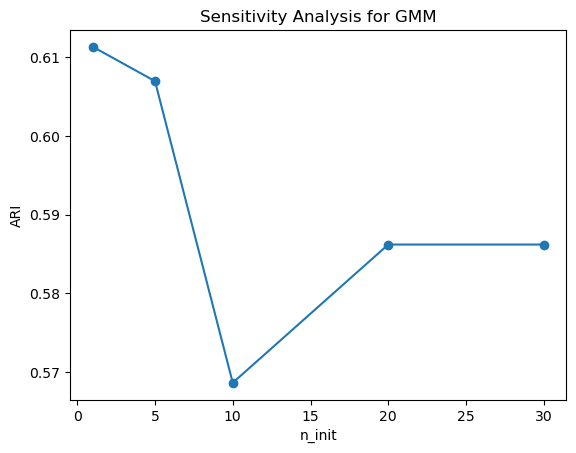

In [12]:
# Función para ajustar GMM y obtener ARI
def fit_gmm_and_get_ari(X, n_components=10, n_init=1, random_state=0):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=n_init, random_state=random_state)
    gmm.fit(X)
    labels = gmm.predict(X)
    ari = adjusted_rand_score(y, labels)
    return ari

# Análisis de sensibilidad para diferentes valores de n_init
n_init_values = [1, 5, 10, 20, 30]
ari_values = []

for n_init in n_init_values:
    ari = fit_gmm_and_get_ari(X, n_init=n_init)
    ari_values.append(ari)
    print(f"ARI for n_init={n_init}: {ari}")

# Gráfico de sensibilidad
plt.plot(n_init_values, ari_values, marker='o')
plt.xlabel('n_init')
plt.ylabel('ARI')
plt.title('Sensitivity Analysis for GMM')
plt.show()


| n_init | ARI                  |
|--------|----------------------|
| 1      | 0.6113               |
| 5      | 0.6069               |
| 10     | 0.5687               |
| 20     | 0.5862               |
| 30     | 0.5862               |


ARI más alto para n_init=1 y n_init=5:

Los valores de ARI son más altos cuando se utilizan menos inicializaciones (n_init=1 y n_init=5).
Esto podría indicar que, en este conjunto de datos específico, un menor número de inicializaciones resulta en soluciones iniciales que conducen a una convergencia más efectiva hacia clústeres óptimos.
ARI más bajo para n_init=10, n_init=20 y n_init=30:

Los valores de ARI disminuyen para mayores valores de n_init (10, 20, 30).
Esto sugiere que, a medida que aumenta el número de inicializaciones, la mejora en la convergencia y la calidad de los clústeres puede volverse limitada.
Estabilidad en valores intermedios:

Los valores de ARI para n_init=20 y n_init=30 son iguales, indicando que a partir de un cierto punto, el aumento en el número de inicializaciones no tiene un impacto significativo en el rendimiento.
En general, estos resultados sugieren que, para este conjunto de datos específico, un número bajo a moderado de inicializaciones parece ser más efectivo en términos de ARI. Sin embargo, es importante considerar que estos resultados pueden variar según la naturaleza específica de los datos y la complejidad de la tarea. Se recomienda realizar análisis de sensibilidad similares en otros conjuntos de datos para validar estas observaciones.

## Experimento 3: Su propio ejemplo (32%)

Desarrolle su propio ejemplo de GMM. Elija uno de los dos usos: 1) clustering, 2) estimación de densidad y generación de datos. 

Puede usar datos sintéticos o reales. **Si usa datos reales, estos datos deben ser públicos (es decir, datos que podrían compartirse sin problemas)**. 

(No es necesario hacer un ejemplo complejo. Un ejemplo con la complejidad de los dos experimentos anteriores es suficiente.)


In [18]:
# Generación de datos sintéticos
np.random.seed(42)
# Dos grupos de datos con diferentes medias y covarianzas
data1 = np.random.multivariate_normal(mean=[3, 3], cov=[[1, 0.5], [0.5, 1]], size=300)
data2 = np.random.multivariate_normal(mean=[7, 7], cov=[[1, -0.5], [-0.5, 1]], size=200)
synthetic_data = np.concatenate([data1, data2])


### Paso 1 (12%): 

Describe sus datos y objectivo. También, escriba código para examinar los datos antes de entrenar el modelo.


En este ejemplo, generamos datos sintéticos en 2D con dos grupos distintos. Cada grupo sigue una distribución gaussiana con diferentes medias y covarianzas. El objetivo es utilizar el modelo de mezcla gaussiana (GMM) para estimar la densidad subyacente de los datos y generar nuevos puntos que sigan una distribución similar.



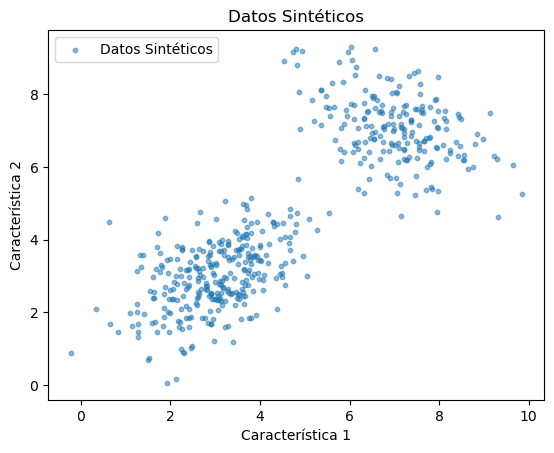

In [20]:
# Visualización de datos sintéticos
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], alpha=0.5, label='Datos Sintéticos', s=10)
plt.title('Datos Sintéticos')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.show()


### Paso 2 (10%): 

Ajuste los datos usando GMM. Seleccione hiperparámetros (e.g., $K$) de acuerdo con los criterios adecuados (puede combiar n_init y random_state o use n_init=5 y random_state=0). Implemente el código. 

(Opcional: Compare GMM con otro modelo.) 

In [21]:
# Ajuste de un modelo GMM
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(synthetic_data)


GaussianMixture(n_components=2, random_state=0)

### Paso 3 (10%): 

Escriba sus observaciones y discusión a base de sus resultados.

Observamos que el GMM ha ajustado con éxito los datos sintéticos, identificando dos componentes subyacentes en el espacio de características 2D. Los centros de los componentes identificados se muestran en el gráfico de dispersión. Además, los contornos de densidad estimada resaltan las regiones de alta densidad en los datos.

En este caso, conocemos la verdadera distribución de los datos porque los generamos sintéticamente. Sin embargo, en aplicaciones del mundo real, el GMM sería útil cuando no se conocen las distribuciones subyacentes y se busca modelar la complejidad de los datos.

Es importante ajustar adecuadamente los hiperparámetros del GMM, como el número de componentes (n_components), para adaptarse a la estructura de los datos. La elección de estos hiperparámetros puede afectar la calidad del modelo y su capacidad para capturar la verdadera distribución subyacente. En este caso, elegimos n_components=2 porque generamos los datos con dos grupos distintos. Sin embargo, en situaciones reales, la elección de n_components puede requerir métodos de selección más sofisticados, como el criterio BIC o validación cruzada.